# Class-Specific Models
In this approach, we use image embeddings and K-means clustering to assign implicit class labels to each sample of the given dataset. We then train a separate ResNet18-UNet model for each implicit class and check if we get an improvement over single ResNet18-UNet model as presented in the *resnet_unet.ipynb* notebook.

In [1]:
import os
import random 
import torch

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

from src_notebooks.utils import *
from src_notebooks.image_embedding import get_embeddings
from src_notebooks.dataset_augmentation import augment_dataset
from src_notebooks.models import ResNet18UNet
from src_notebooks.pytorch_utils import *

### Image Embeddings
As a first step, we use the ResNet-18 model that was pretrained on the ImageNet dataset to generate embeddings for each image in our dataset. For that, we feed each image into the model and use the output of the *avgpool* layer as the embedding of the image. This is the layer at the end of the network, after the flattening and before the fully-connected layer *(see orange arrow below)*.

We adopted the code for the generation of the embeddings from the following blog (from which we also took the image below): https://becominghuman.ai/extract-a-feature-vector-for-any-image-with-pytorch-9717561d1d4c

![](https://miro.medium.com/max/1400/1*1BEDb6N5T4ZRZVb31IpKsw.png)

In [2]:
# load training and test set
images_train = load_pil_images(os.path.join("training", "images"))
images_test = load_pil_images(os.path.join("test", "images"))
masks_train = load_pil_images(os.path.join("training", "groundtruth"))

# generate embeddings for each image
features_train = get_embeddings(images_train)
features_test = get_embeddings(images_test)

### K-Means Clustering

Now, we perform K-means clustering with the generated image embeddings. We tried out different values for *K* and in our opinion *K=3* produces the most convincing results.

In [3]:
K = 3

# standardize embeddings
scaler = StandardScaler()
images_train_scaled = scaler.fit_transform(features_train)

# apply k-means clustering and get class labels of training set
kmeans = KMeans(init="k-means++", n_clusters=K, random_state=1)
kmeans.fit(images_train_scaled)
labels_train = kmeans.labels_

# count number of class occurences
print("\nTraining set:")
for i in range(K):
    count = list(labels_train).count(i)
    fraction = float(count) / len(labels_train)
    print(f"Number of images in class {i}:\t{count} ({int(fraction * 100)}%)")


Training set:
Number of images in class 0:	35 (24%)
Number of images in class 1:	65 (45%)
Number of images in class 2:	44 (30%)


Let us plot some example images from the training set for each implicit class.

Class 0:


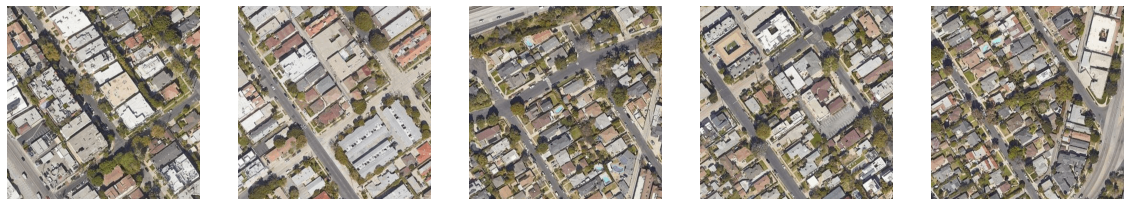

Class 1:


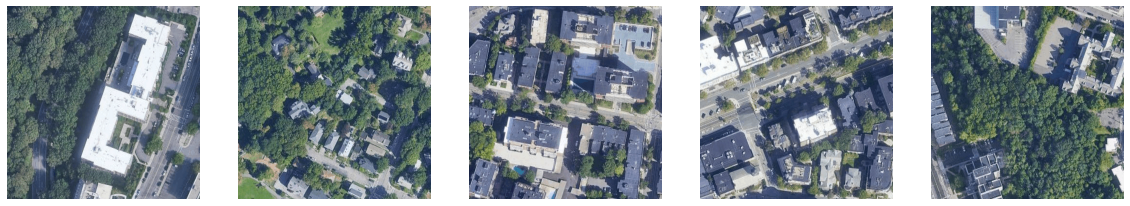

Class 2:


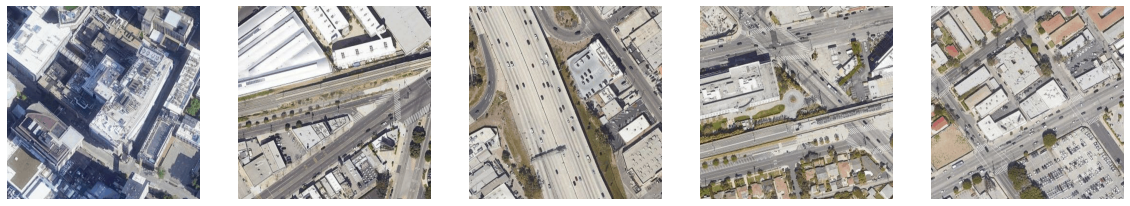

In [20]:
n_images_to_plot = 5

for k in range(K):
    idx = np.where(labels_train == i)
    imgs = [images_train[i] for i in range(len(images_train)) if labels_train[i] == k]
    print(f"Class {k}:")
    plot_images(random.sample(imgs, n_images_to_plot))


Let us now take the fitted K-means model and predict the implicit class labels for the test set.

In [4]:
# standardize embeddings
images_test_scaled = scaler.fit_transform(features_test)

# predict class labels for test set
labels_test = kmeans.predict(images_test_scaled)

# count number of class occurences
print("\nTest set:")
for i in range(K):
    count = list(labels_test).count(i)
    fraction = float(count) / len(labels_test)
    print(f"Number of images in class {i}:\t{count} ({int(fraction * 100)}%)")


Test set:
Number of images in class 0:	25 (17%)
Number of images in class 1:	66 (45%)
Number of images in class 2:	53 (36%)


Let us plot some example images from the test set for each implicit class.

Class 0:


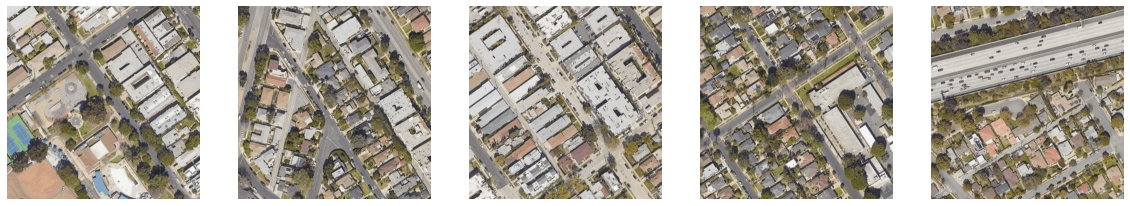

Class 1:


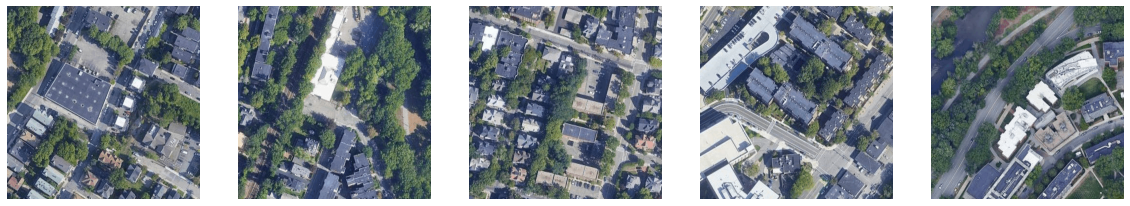

Class 2:


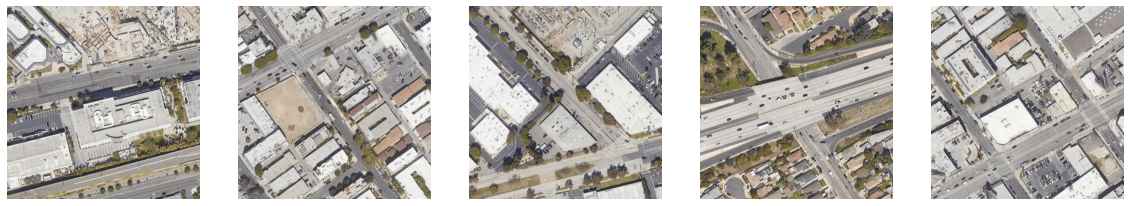

In [36]:
n_images_to_plot = 5

for k in range(K):
    idx = np.where(labels_test == i)
    imgs = [images_test[i] for i in range(len(images_test)) if labels_test[i] == k]
    print(f"Class {k}:")
    plot_images(random.sample(imgs, n_images_to_plot))

Let us save the class labels in case we need them later.

In [5]:
os.makedirs("class_labels", exist_ok=True)

with open(os.path.join("class_labels", "labels_train.npy"), "wb") as f:
    np.save(f, labels_train)

with open(os.path.join("class_labels", "labels_test.npy"), "wb") as f:
    np.save(f, labels_test)

The results can be interpreted as follows:
* Class 0: Small & medium-sized buildings and roads, roads are mostly straight and well visible.
* Class 1: Many small and curvy roads, many streets are occluded by trees.
* Class 2: Mediam & large buildings, roads are mostly straight and well visible, many wide roads and highways.

Each class clearly has a very distinct appearance as well as different types of segmentation maps for the roads (e.g. highway with many lanes vs. narrow street, well-visible parallel streets vs. completely occluded roads, etc.). In some ways, different subtasks need to be solved for each class. Since we have very little training data, we wanted to try out if better results can be achieved by training a seperate model for different groups of subtasks instead of a single model that has to generalize to everything using very little data.

### Dataset Augmentation
Let us now create an extended dataset for each class using the augmentation methods presented in *augmentation_experiments.ipynb*.

In [6]:
n_samples_per_img = [15, 20, 15] # number of new samples to generate for each class

for k in range(K):
    idx = np.where(labels_train == i)
    imgs = [images_train[i] for i in range(len(images_train)) if labels_train[i] == k]
    masks = [masks_train[i] for i in range(len(images_train)) if labels_train[i] == k]

    augment_dataset(
        imgs=imgs, 
        masks=masks,
        n_samples_per_img=n_samples_per_img[k],
        class_label=k,
        dir="training_ext_classes",
    )

Image 525/525
Image 1300/1300
Image 660/660


### Training and Prediction with Class-Specific Models

Now we have an augmented dataset for each implicit class. Let us train each model and use them to make predictions on the test set.

In [ ]:
K = 3
save_models = True # whether or not to save backup of models

device = 'cuda' if torch.cuda.is_available() else 'cpu'

models = []
histories = []
val_sizes = [45, 120, 60] # number validation samples are chosen in a way such that there is no information leakage, 
                          # i.e. all augmented versions of an original sample are in the same set.

for k in range(K):
    # get filenames of all the training samples from the extended dataset
    image_fns = sorted(glob(os.path.join("training_ext_classes", "images", f"{k}_*.png")))
    mask_fns = sorted(glob(os.path.join("training_ext_classes", "groundtruth", f"{k}_*.png")))

    resnet_unet = ResNet18UNet(pretrained=True).to(device)
    history = train_model(
        model=resnet_unet,
        image_fns_train=image_fns[:-val_sizes[k]],
        mask_fns_train=mask_fns[:-val_sizes[k]],
        image_fns_val=image_fns[-val_sizes[k]:],
        mask_fns_val=mask_fns[-val_sizes[k]:],
        n_epochs=30,
        batch_size=4,
        resize_shape=(384, 384),
    )

    models.append(resnet_unet)
    histories.append(history)

    if save_models:
        os.makedirs("model_backups", exist_ok=True)
        torch.save(resnet_unet.state_dict(), os.path.join("model_backups", f"resnet_unet_class_{k}")) 

Class 0:


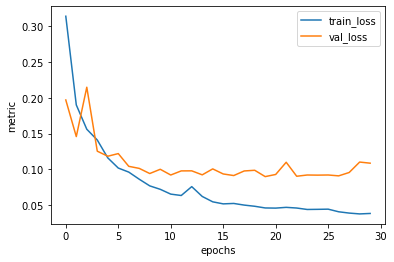

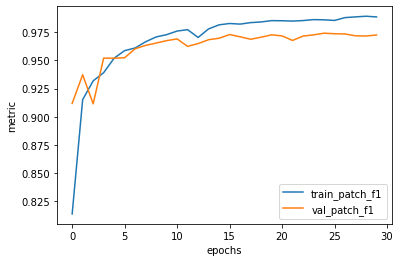

Class 1:


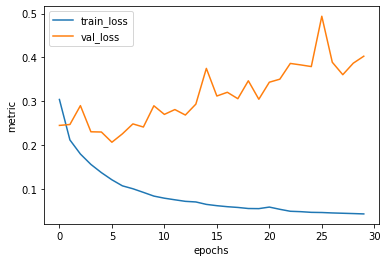

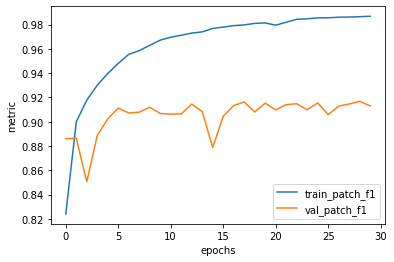

Class 2:


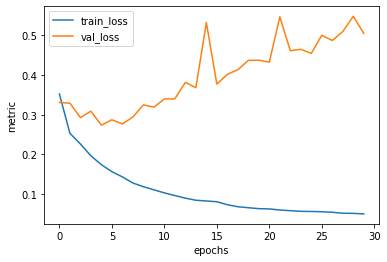

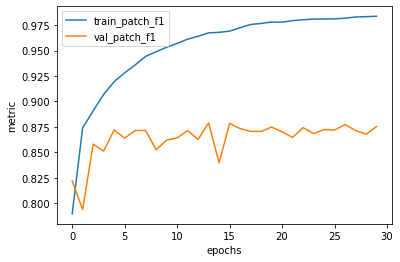

In [8]:
for k in range(K):
    print(f"Class {k}:")
    plot_training_history(histories[k])

Execute the following code cell if the labels and models were created in a previous session.

In [3]:
K = 3
device = 'cuda' if torch.cuda.is_available() else 'cpu'

models = []

for k in range(K):
    m = ResNet18UNet().to(device)
    m.load_state_dict(torch.load(os.path.join("model_backups", f"resnet_unet_class_{k}")))
    models.append(m)

with open(os.path.join("class_labels", "labels_test.npy"), 'rb') as f:
    labels_test = np.load(f)

Using these specialized models, we get a slight improvement over using a single model and achieve a public score of about 0.910 on Kaggle. However, a few weeks after trying out this approach, we found a way to generate arbitrary large datasets using the Google Maps API. Thus, training a model that is able to generalize to all kinds of roads was not a problem anymore.

In [ ]:
preds = predict_on_test_set(
    models, 
    implicit_class_labels=labels_test,
    resize_shape=(384, 384), 
    submission_fn="class_specific_models.csv"
)
plot_predictions(preds)